<a href="https://colab.research.google.com/github/victorsergio/lstm-pedestrian-prediction-keras/blob/master/LSTM_pedestrian_stanford.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function

import glob
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

import numpy as np
import pandas as pd
import re
from google.colab import drive
from pandas import read_csv
from numpy import array
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adagrad
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.constraints import maxnorm
from keras.models import load_model
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.utils import plot_model
import random
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM


pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

Using TensorFlow backend.


In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# For use TensorBoard on Colab
!pip install -U tensorboardcolab

from tensorboardcolab import *
tensorboard_callback=TensorBoardColab()

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.22)
Wait for 8 seconds...
TensorBoard link:
https://6e2fe99b.ngrok.io


In [0]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
        
    return array(X), array(y)

In [0]:
def sequences_to_supervised(dataframe, n_steps, n_features):
  
  # the sequences must by arranged
  # in a supervised learning structure.
  # this function reads line by line each sequence and arrange in a supervised learning aproach structure
  # it's important to notice that sequences must not overlap, to mantain pedestrian independence
       
  X_all = np.empty([0,n_steps,n_features]) # n_features = number of features, x, y, time
  y_all = np.empty([0,n_features]) # same here, n_features = number of features
       
  dataframe_groups = dataframe.groupby(['id'])
  
  # randomize sequences grouped by pedestrian id
  groups = list(dataframe.groupby(['id']))
  random.shuffle(groups)
 

  for group in groups:
      
      # send pedestrian sequence dataframe to step sequence generator function
      #X, y = split_sequences(group[1].drop(columns=["id"]).values, n_steps) #use 3 features, time, x, y
      X, y = split_sequences(group[1].drop(columns=["id","time"]).values, n_steps) # use 2 features, x, y
         
      X_all = np.concatenate((X_all,X))
      y_all = np.concatenate((y_all,y))
             
  return X_all, y_all         

In [0]:
# split a multivariate dataset into train/test sets
def split_dataset(X,y,train_samples,test_samples):
   
  X_train = X[0:train_samples,:,:]
  X_test  = X[train_samples:(train_samples+test_samples),:,:]
  
  y_train = y[0:train_samples,:]
  y_test =  y[train_samples:(train_samples+test_samples),:]
  
  return X_train, y_train, X_test, y_test

In [0]:
path = "/content/drive/My Drive/research/data/stanford-image/"

inputFileName = "bookstore_0.txt"

# choose a number of time steps
# previous time steps for each sequence split
n_steps = 8

#n_features = 3  # time, x, y
n_features = 2   #x, y


In [0]:
import glob

dataframe = pd.concat([pd.read_csv(f, sep=' ', header=None, names=['time', 'id', 'x', 'y']) for f in glob.glob(path+'bookstore_*.txt')], ignore_index=True)


#dataframe = pd.read_csv(path + inputFileName, sep=' ', header=None, names=['time', 'id', 'x', 'y'])

# min max scaling
# normalize all columns but not id column

id_column = dataframe['id']
dataframe = dataframe.drop(columns="id")

scaler = MinMaxScaler()
dataframe = pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

dataframe = dataframe.join(id_column) # re insert the id column to the scaled dataframe

X, y = sequences_to_supervised(dataframe, n_steps, n_features)

# show the prepared data dimensions with the supervised learning structure
# multivariate input, multivariate output, single step output, multistep input
print("supervised dataframe dimensions: ")
print(X.shape, y.shape,"\n")

# show first 3 elements
for i in range(3):
    print(X[i], y[i])


supervised dataframe dimensions: 
(28992, 8, 2) (28992, 2) 

[[0.02452204 0.01401869]
 [0.02452204 0.01588785]
 [0.02452204 0.02336449]
 [0.02452204 0.03084112]
 [0.02381105 0.04392523]
 [0.02381105 0.05700935]
 [0.02381105 0.07196262]
 [0.02381105 0.08598131]] [0.02381105 0.09859813]
[[0.02452204 0.01588785]
 [0.02452204 0.02336449]
 [0.02452204 0.03084112]
 [0.02381105 0.04392523]
 [0.02381105 0.05700935]
 [0.02381105 0.07196262]
 [0.02381105 0.08598131]
 [0.02381105 0.09859813]] [0.02238907 0.1135514 ]
[[0.02452204 0.02336449]
 [0.02452204 0.03084112]
 [0.02381105 0.04392523]
 [0.02381105 0.05700935]
 [0.02381105 0.07196262]
 [0.02381105 0.08598131]
 [0.02381105 0.09859813]
 [0.02238907 0.1135514 ]] [0.02238907 0.12616822]


In [0]:

# split into train and test
X, y, X_test, y_test = split_dataset(X,y,23000,5992)

# print train and test set dimensions
print("\ntrain set: ",X.shape, y.shape,"\n")
print("test set: ",X_test.shape, y_test.shape,"\n")  



train set:  (23000, 8, 2) (23000, 2) 

test set:  (5992, 8, 2) (5992, 2) 



In [0]:
#@title
# flatten input
#n_input = X.shape[1] * X.shape[2]
#X = X.reshape((X.shape[0], n_input))


# separate output
y1 = y[:, 0] #.reshape((y.shape[0], 1))  # time or x with 2 features 
y2 = y[:, 1] #.reshape((y.shape[0], 1))  # x or y with 2 features
# y3 = y[:, 2].reshape((y.shape[0], 1))  # y


# flatten test input
#n_input = X_test.shape[1] * X_test.shape[2]
#X_test = X_test.reshape((X_test.shape[0], n_input))

# separate test output
y1_test = y_test[:, 0] #.reshape((y_test.shape[0], 1)) # time or x with 2 features
y2_test = y_test[:, 1] #.reshape((y_test.shape[0], 1)) # x or y with 2 features
# y3_test = y_test[:, 2].reshape((y_test.shape[0], 1)) # y


In [0]:
n_features = X.shape[2]

# define model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(2))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
batch_size = 16
learning_rate = 0.003

In [0]:
#@title
# define model
visible = Input(shape=(n_input,))
#dropout_visible = Dropout(0.1)(visible)

dense1 = Dense(2048, name='dense_1', use_bias=False, kernel_regularizer=regularizers.l2(0.1),kernel_constraint=maxnorm(10))(visible)
activation1 = Activation('relu')(dense1)
batchnorm1 = BatchNormalization()(activation1)
dropout1 = Dropout(0.4)(batchnorm1)

dense2 = Dense(1024,  name='dense_2', use_bias=False, activation='relu',kernel_regularizer=regularizers.l2(0.1),kernel_constraint=maxnorm(10))(dropout1)
activation2 = Activation('relu')(dense2)
batchnorm2 = BatchNormalization()(activation2)
dropout2 = Dropout(0.4)(batchnorm2)

dense3 = Dense(512,  name='dense_3',use_bias=False, activation='relu',kernel_regularizer=regularizers.l2(0.1),kernel_constraint=maxnorm(10))(dropout2)
activation3 = Activation('relu')(dense3)
batchnorm3 = BatchNormalization()(activation3)
dropout3 = Dropout(0.4)(batchnorm3)

#dense4 = Dense(128,  name='dense_4',use_bias=False, activation='relu',kernel_regularizer=regularizers.l2(0.0),kernel_constraint=maxnorm(10))(dropout3)
#activation4 = Activation('relu')(dense4)
#batchnorm4 = BatchNormalization()(activation4)
#dropout4 = Dropout(0.5)(batchnorm4)

# define output 1
output1 = Dense(1, name='x_output_1')(dropout3)
# define output 2
output2 = Dense(1, name='y_output_2')(dropout3)
# define output 3
#output3 = Dense(1, name='y_output_3')(dropout3)



In [0]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:

optimizer = Adagrad(lr=learning_rate, epsilon=None, decay=0.0)

# tie together
#model = Model(inputs=visible, outputs=[output1, output2, output3])

# 2 features x, y
#model = Model(inputs=visible, outputs=[output1, output2])

model.compile(optimizer=optimizer, loss='mse',metrics=['mae'])

# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file=path+'graphs/LSTM-pedestrian-stanford-graph.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17152     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 17,282
Trainable params: 17,282
Non-trainable params: 0
_________________________________________________________________
None


In [0]:

# checkpoint
filepath = path + "models/LSTM-pedestrian-stanford-model-weights.best.hdf5"
checkpoint_call = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# tensorboard
tboard_call = TensorBoardColabCallback(tensorboard_callback)

# callbacks
callbacks_list = [checkpoint_call,tboard_call]




In [0]:
#UNCOMMENT AND RUN THIS SECTION FOR RELOAD THE MODEL FROM LAST .HDF5 FILE AND CONTINUE TRAINING

# Reload model for re-training

#model = load_model(path+'models/MLP-pedestrian-stanford-model-weights.best.hdf5')


In [0]:
# fit model
#history = model.fit(X, [y1,y2,y3], epochs=200, verbose=0, validation_split=0.20, batch_size=batch_size,callbacks=callbacks_list)

# 2 features x,y
#history = model.fit(X, [y1,y2], epochs=10, verbose=0, validation_split=0.20, batch_size=batch_size,callbacks=callbacks_list) 

history = model.fit(X, y, epochs=200, verbose=0, validation_split=0.20, batch_size=batch_size,callbacks=callbacks_list) 



Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.01226, saving model to /content/drive/My Drive/research/data/stanford-image/models/LSTM-pedestrian-stanford-model-weights.best.hdf5

Epoch 00002: val_loss improved from 0.01226 to 0.00885, saving model to /content/drive/My Drive/research/data/stanford-image/models/LSTM-pedestrian-stanford-model-weights.best.hdf5

Epoch 00003: val_loss improved from 0.00885 to 0.00797, saving model to /content/drive/My Drive/research/data/stanford-image/models/LSTM-pedestrian-stanford-model-weights.best.hdf5

Epoch 00004: val_loss improved from 0.00797 to 0.00770, saving model to /content/drive/My Drive/research/data/stanford-image/models/LSTM-pedestrian-stanford-model-weights.best.hdf5

Epoch 00005: val_loss improved from 0.00770 to 0.00738, saving model to /content/drive/My Drive/research/data/stanford-image/models/LSTM-pedestrian-stanford-model-weights.best.hdf5

Epoch 00006: val_loss improved from 0.00738 t

In [0]:
model = load_model(path+'models/LSTM-pedestrian-stanford-model-weights.best.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
#score = model.evaluate(X_test, [y1_test,y2_test,y3_test], verbose=1, batch_size=batch_size)

# 2 features, x, y
#score = model.evaluate(X_test, [y1_test,y2_test], verbose=1, batch_size=batch_size)

score = model.evaluate(X_test, y_test, verbose=1, batch_size=batch_size)


print("\n")
print(model.metrics_names)
print(score)

5992/5992 [==============================] - 2s 392us/step


['loss', 'mean_absolute_error']
[0.005985009963970686, 0.021583317220086686]


In [0]:
#@title
print("Min values: ", scaler.data_min_)
print("Max value: ",scaler.data_max_)

mae_x = scaler.inverse_transform(array([0,score[3],0]).reshape(1, -1))
mae_y = scaler.inverse_transform(array([0,0,score[4]]).reshape(1, -1))

print("MAE X:",score[3],"MAE Y:",score[4])
print("MAE X: ", mae_x[0][1],"MAE Y:",mae_y[0][2] )

Min values:  [0.   7.51 8.5 ]
Max value:  [14532.   1414.   1078.5]
MAE X: 0.021438995991722845 MAE Y: 0.02454203548275422
MAE X:  37.66373347239826 MAE Y: 34.75997796654701


In [0]:
def test_predictions(n_input,sample):

    path = "/content/drive/My Drive/research/data/stanford-image/"
    inputFileName = "test_bookstore_3.txt"
    
    

    # choose a number of time steps
    # previous time steps for each sequence split
    n_steps = 8
    n_features = 2  # x, y

    dataframe = pd.read_csv(path + inputFileName, sep=' ', header=None, names=['time', 'id', 'x', 'y'])

    # min max scaling
    # normalize all columns but not id column

    id_column = dataframe['id']
    dataframe = dataframe.drop(columns=["id","time"])

    scaler = MinMaxScaler()
    dataframe = pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

    dataframe = dataframe.join(id_column) # re insert the id column to the scaled dataframe
    
    
    dataframe_groups = dataframe.groupby(['id'])
  
    # randomize sequences grouped by pedestrian id
    groups = list(dataframe.groupby(['id']))
    #random.shuffle(groups)
 

    
    g = groups[sample]
    
    print(g[0])
  
    pedestrian_group = g[1].drop(columns="id").values
    
    #window = pedestrian_group[0:8,:]
   
    predicted_trajectory = pedestrian_group[0:8,:] # initial points
      
    #multistep = 12
    multistep = 12
    
    #for j in range(0,pedestrian_group.shape[0]-8,multistep):
    for j in range (0,1):
        #window = pedestrian_group[j:j+8,:]
        window = pedestrian_group[0:8,:]
    
        for i in range(0,multistep):
        
            input_steps = window[i:i+8,:]
        
            #x_input = input_steps.reshape(1,n_input)
          
            x_input = input_steps.reshape(1,n_steps,n_features)
          
            yhat = model.predict(x_input,verbose=0)
        
               
            yhat_results = np.array([yhat[0][0],yhat[0][1]]).reshape(1,-1)
            
            #yhat_results = np.array([yhat[0][0],yhat[1][0]]).reshape(1,-1)
             
            #print(yhat)
        
            predicted_trajectory = np.append(predicted_trajectory, yhat_results,axis=0)
            window = np.append(window,yhat_results,axis=0)
        
        
    
    
        
        
    predicted = scaler.inverse_transform(predicted_trajectory)
    ground_truth = scaler.inverse_transform(pedestrian_group)
    
    e = 0
    
    for i in range(0,len(predicted)):
        e = e + math.sqrt (((predicted[i,0]- ground_truth[i,0]) ** 2) + ((predicted[i,1]- ground_truth[i,1]) ** 2))
        
    e = e / len(predicted)
    
    
    d = 0
    d = d + math.sqrt (((predicted[len(predicted)-1,0]- ground_truth[len(ground_truth)-1,0]) ** 2) + ((predicted[len(predicted)-1,1]- ground_truth[len(ground_truth)-1,1]) ** 2))
    
    
        
    
    
    print("L2 error: ",e)
    print("Displacement error:",d)
    print("predicted shape:",predicted.shape)
    print("predicted values:\n",predicted)
    print("ground truth values:\n",ground_truth)
    
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
 
    # Prints: [8.0, 6.0]
    #print ("Current size:", fig_size)
 
    # Set figure width to 12 and height to 9
    fig_size[0] = 24
    fig_size[1] = 18
    plt.rcParams["figure.figsize"] = fig_size
    
    
    img = plt.imread(path+"background/bookstore_video0.jpg")
    fig, ax = plt.subplots()
    
    #x = range(300)
    #ax.imshow(img, extent=[0, 400, 0, 300])
    ax.imshow(img)    
    #ax.style.use('seaborn-whitegrid')
    ax.plot(ground_truth[:,0],ground_truth[:,1],'-o',color='red')
    ax.plot(predicted[:,0],predicted[:,1],'-o',color='blue')
    plt.show()



40
L2 error:  66.56694224146698
Displacement error: 196.00083016129227
predicted shape: (20, 2)
predicted values:
 [[539.         472.5       ]
 [561.         466.        ]
 [578.         461.5       ]
 [592.5        459.5       ]
 [603.5        459.5       ]
 [607.         459.5       ]
 [613.         459.5       ]
 [622.         461.5       ]
 [621.67965634 465.37848957]
 [622.22978261 469.01403949]
 [622.95829362 472.6875557 ]
 [623.80130598 476.28108621]
 [624.84023513 479.93576176]
 [626.02488975 483.55481423]
 [627.27284594 487.01006383]
 [628.57436797 490.32817245]
 [629.86464156 493.54587145]
 [631.15243274 496.66107096]
 [632.44014634 499.68308046]
 [633.73038115 502.6170297 ]]
ground truth values:
 [[539.  472.5]
 [561.  466. ]
 [578.  461.5]
 [592.5 459.5]
 [603.5 459.5]
 [607.  459.5]
 [613.  459.5]
 [622.  461.5]
 [644.  457. ]
 [662.  461.5]
 [679.  460.5]
 [694.5 456. ]
 [708.  452.5]
 [724.  448. ]
 [737.5 443.5]
 [752.5 439. ]
 [767.  434.5]
 [781.5 428. ]
 [796.5 423.

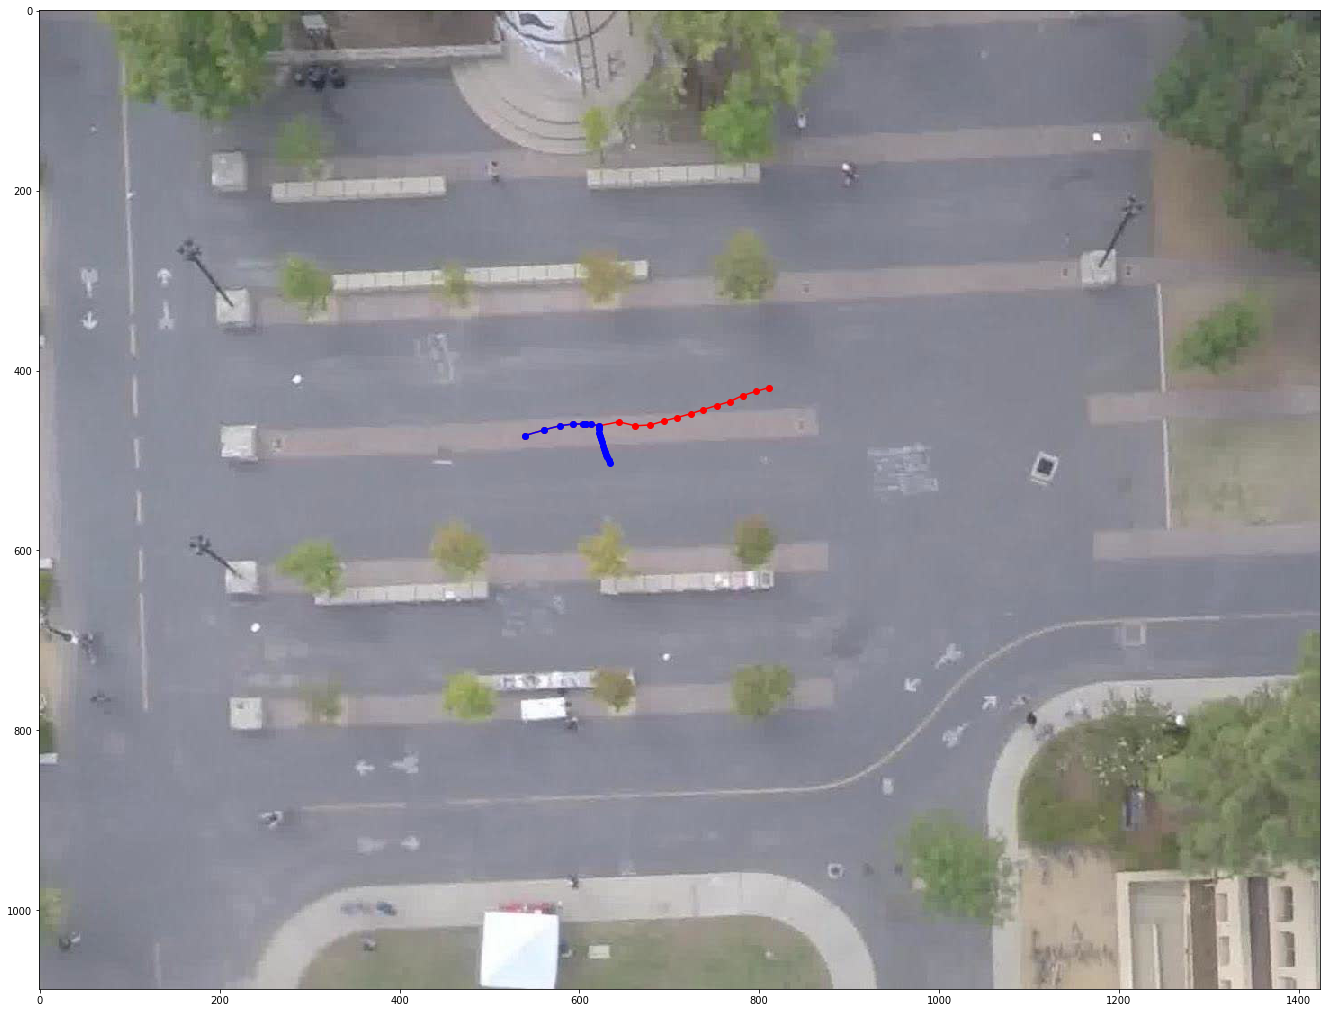

In [0]:
test_predictions(n_input=0, sample = 40)


In [0]:
#@title
def test_predictions(n_input):

    path = "/content/drive/My Drive/research/data/stanford-image/"
    inputFileName = "bookstore_1.txt"
    
    

    # choose a number of time steps
    # previous time steps for each sequence split
    n_steps = 8
    n_features = 2  # x, y

    dataframe = pd.read_csv(path + inputFileName, sep=' ', header=None, names=['time', 'id', 'x', 'y'])

    # min max scaling
    # normalize all columns but not id column

    id_column = dataframe['id']
    dataframe = dataframe.drop(columns=["id","time"])

    scaler = MinMaxScaler()
    dataframe = pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

    dataframe = dataframe.join(id_column) # re insert the id column to the scaled dataframe
    
    
    dataframe_groups = dataframe.groupby(['id'])
  
    # randomize sequences grouped by pedestrian id
    groups = list(dataframe.groupby(['id']))
    #random.shuffle(groups)
 

    
    g = groups[0]
    
    print(g[0])
  
    pedestrian_group = g[1].drop(columns="id").values
    
    #print(pedestrian_group.shape())
    
    #print(pedestrian_group)
        
    #source_steps = pedestrian_group[0:8,:]
    #input_steps = source_steps
    
    
    predicted_trajectory = np.empty([0, 2])
      
        
    for i in range(0,pedestrian_group.):
        
        input_steps = pedestrian_group[i:i+8,:]
        
        x_input = input_steps.reshape(1,n_input)        
        yhat = model.predict(x_input,verbose=0)
        
               
        yhat_results = np.array([yhat[0][0],yhat[1][0]]).reshape(1,-1)
        
        source_steps = np.append(predicted_trajectory, yhat_results,axis=0)
        
        
    
    upload = scaler.inverse_transform(source_steps)
    gt = scaler.inverse_transform(pedestrian_group)
    
    e = 0
    
    for i in range(0,len(upload)):
        e = e + math.sqrt (((upload[i,0]- gt[i,0]) ** 2) + ((upload[i,1]- gt[i,1]) ** 2))
        
    e = e / len(upload)
        
    
    
    print("L2 error: ",e)
    
    plt.style.use('seaborn-whitegrid')
    plt.plot(gt[:,0],gt[:,1],'-o',color='red')
    plt.plot(upload[:,0],upload[:,1],'-o',color='blue')
    plt.show()
    

In [0]:
#@title
def test_predictions(n_input):

    path = "/content/drive/My Drive/pedestrian lstm/data/stanford/"
    inputFileName = "bookstore_1.txt"
    
    

    # choose a number of time steps
    # previous time steps for each sequence split
    n_steps = 8
    n_features = 3  # time, x, y

    dataframe = pd.read_csv(path + inputFileName, sep=' ', header=None, names=['time', 'id', 'x', 'y'])

    # min max scaling
    # normalize all columns but not id column

    id_column = dataframe['id']
    dataframe = dataframe.drop(columns="id")

    scaler = MinMaxScaler()
    dataframe = pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

    dataframe = dataframe.join(id_column) # re insert the id column to the scaled dataframe
    
    
    dataframe_groups = dataframe.groupby(['id'])
  
    # randomize sequences grouped by pedestrian id
    groups = list(dataframe.groupby(['id']))
    random.shuffle(groups)
 

    #g = groups[227]
    g = groups[0]
    
    print(g[0])
  
    pedestrian_group = g[1].drop(columns="id").values
    
    #print(pedestrian_group)
        
    source_steps = pedestrian_group[0:8,:]
    input_steps = source_steps
    
      
        
    for i in range(0,12):
        
        
        x_input = input_steps.reshape(1,n_input)        
        yhat = model.predict(x_input,verbose=0)
        
        
        
        yhat_results = np.array([yhat[0][0],yhat[1][0],yhat[2][0]]).reshape(1,-1)
        
       
        
        source_steps = np.append(source_steps, yhat_results,axis=0)
        input_steps = source_steps[i:i+8,:]
        
    
    upload = scaler.inverse_transform(source_steps)
    gt = scaler.inverse_transform(pedestrian_group)
    
    e = 0
    
    for i in range(0,len(upload)):
        e = e + math.sqrt (((upload[i,1]- gt[i,1]) ** 2) + ((upload[i,2]- gt[i,2]) ** 2))
        
    e = e / len(upload)
        
    
    
    print("L2 error: ",e)
    
    plt.style.use('seaborn-whitegrid')
    plt.plot(gt[:,1],gt[:,2],'-o',color='red')
    plt.plot(upload[:,1],upload[:,2],'-o',color='blue')
    plt.show()
    
    
    #print(diff_mean(gt, upload))
    
    
    #print(source_steps)
    #print(pedestrian_group)
                     
    
    
    
    

In [0]:
#@title
test_predictions(n_input=24)

In [0]:
#@title
    
  
  
  
  n = randint(0, len(X_test))
  
  
  x_input = X_test[i+n].reshape(1,n_input)
    
    yhat = model.predict(x_input,verbose=0)
    results.append(yhat)

In [0]:
#@title
from random import randint

def show_random_sample_prediction():

  results = []
  results_x = []
  results_y = []

  expected_x = []
  expected_y = []


  n = randint(0, 100)  #random sample position from set, multiple from n_steps, size of test dataset
  pedestrian_steps = 20

  for i in range(pedestrian_steps):
    
    x_input = X_test[i+n].reshape(1,n_input)
    
    yhat = model.predict(x_input,verbose=0)
    results.append(yhat)
  

  for j in range(pedestrian_steps):
    results_x.append(denormalize(results[j][0],center_x_max_value,center_x_min_value))
    results_y.append(denormalize(results[j][1],center_y_max_value,center_y_min_value))
  
    expected_x.append(denormalize(y1_test[j+n],center_x_max_value,center_x_min_value))
    expected_y.append(denormalize(y2_test[j+n],center_y_max_value,center_y_min_value))
    
    
  
  results_x = np.array(results_x).reshape(-1)
  results_y = np.array(results_y).reshape(-1)

  expected_x = np.array(expected_x).reshape(-1)
  expected_y = np.array(expected_y).reshape(-1)

  #results arrays
  #print(results_x)
  #print(results_y)
  #print(expected_x)
  #print(expected_y)
  
  plt.style.use('seaborn-whitegrid')

  print(expected_x[0],expected_y[0],results_x[0],results_y[0])
  plt.plot(expected_x,expected_y,'-o',color='red')
  plt.plot(results_x,results_y,'-o',color='blue')
  plt.show()

In [0]:
#@title
# Run this multiple times to observe different random sample from test dataset
show_random_sample_prediction()

In [0]:
# code for create a new graph on tensorboard for each training 

import os
os.rename("Graph/training","Graph/training-01")
os.rename("Graph/validation","Graph/validation-01")

